In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

In [2]:
# Step 1: Load the data
(ds_train, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

In [3]:
ds_info

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_dir='C:\\Users\\Vignesh\\tensorflow_datasets\\beans\\0.1.0',
    file_format=tfrecord,
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
       

In [4]:
# Step 2: Preprocess the data
IMG_SIZE = 224  # MobileNet standard input size
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1] range
    return image, label

ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

<Figure size 1000x1000 with 0 Axes>

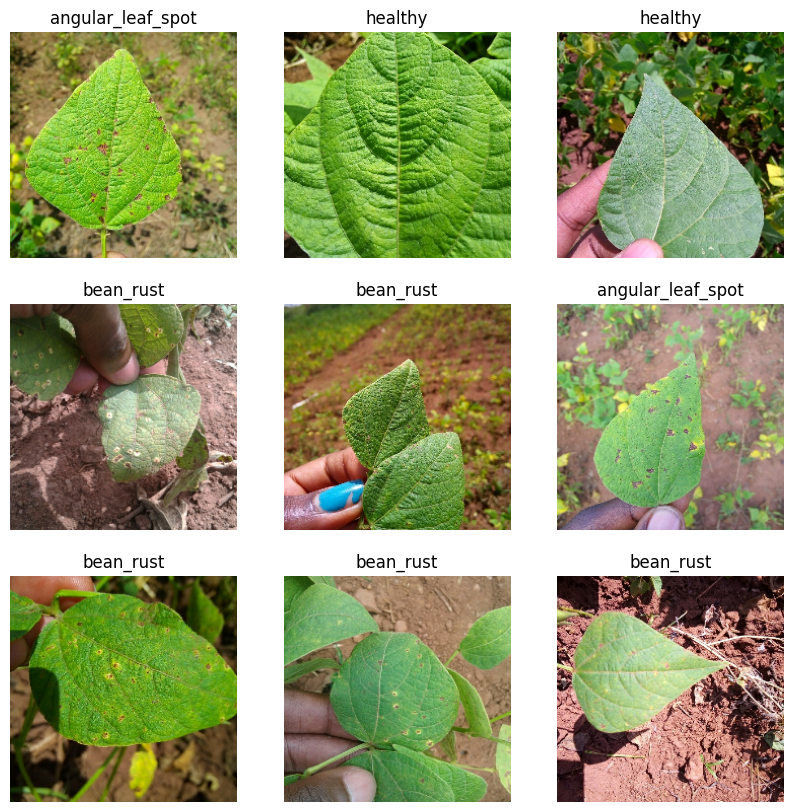

In [5]:

# Step 3: Visualize the data
class_names = ds_info.features['label'].names
plt.figure(figsize=(10, 10))
# Unbatch the dataset for visualization and shuffle it
ds_train_unbatched = ds_train.unbatch().shuffle(buffer_size=1000)

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train_unbatched.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(class_names[label.numpy()])
    plt.axis("off")
plt.show()

In [6]:

# Step 4: Load MobileNet for Transfer Learning
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add new classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 5: Apply Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 892ms/step - accuracy: 0.6196 - loss: 0.8343 - val_accuracy: 0.8594 - val_loss: 0.3224
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 880ms/step - accuracy: 0.9072 - loss: 0.2464 - val_accuracy: 0.8906 - val_loss: 0.2536
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 796ms/step - accuracy: 0.9431 - loss: 0.1559 - val_accuracy: 0.8828 - val_loss: 0.2662
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 756ms/step - accuracy: 0.9595 - loss: 0.1307 - val_accuracy: 0.8750 - val_loss: 0.2843
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 828ms/step - accuracy: 0.9791 - loss: 0.0909 - val_accuracy: 0.8984 - val_loss: 0.2355
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 820ms/step - accuracy: 0.9854 - loss: 0.0543 - val_accuracy: 0.8906 - val_loss: 0.2176
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 801ms/step - accuracy: 0.9965 - loss: 0.0370 - val_accuracy: 0.8984 - val_loss: 0.2189
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 800ms/step - accuracy: 0.9998 - loss: 0.0287 - val_accu

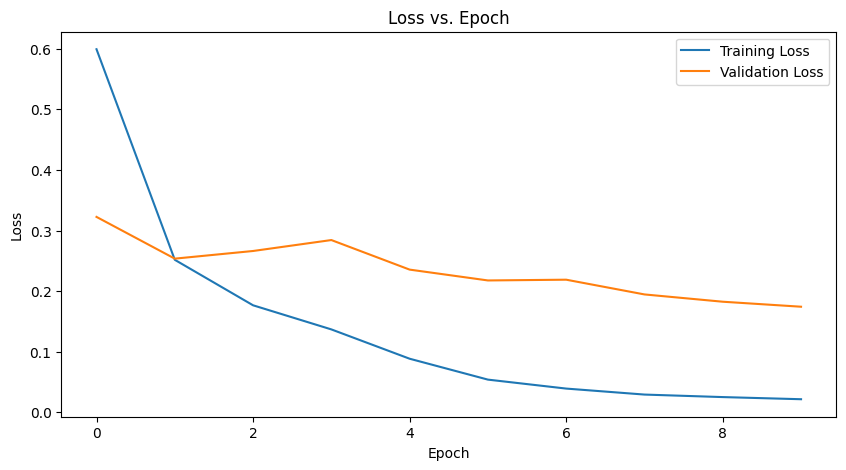

In [7]:
# Step 6: Train the Model
history = model.fit(ds_train, epochs=10, validation_data=ds_test, callbacks=[early_stopping])

# Step 7: Plot Loss vs. Epoch
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


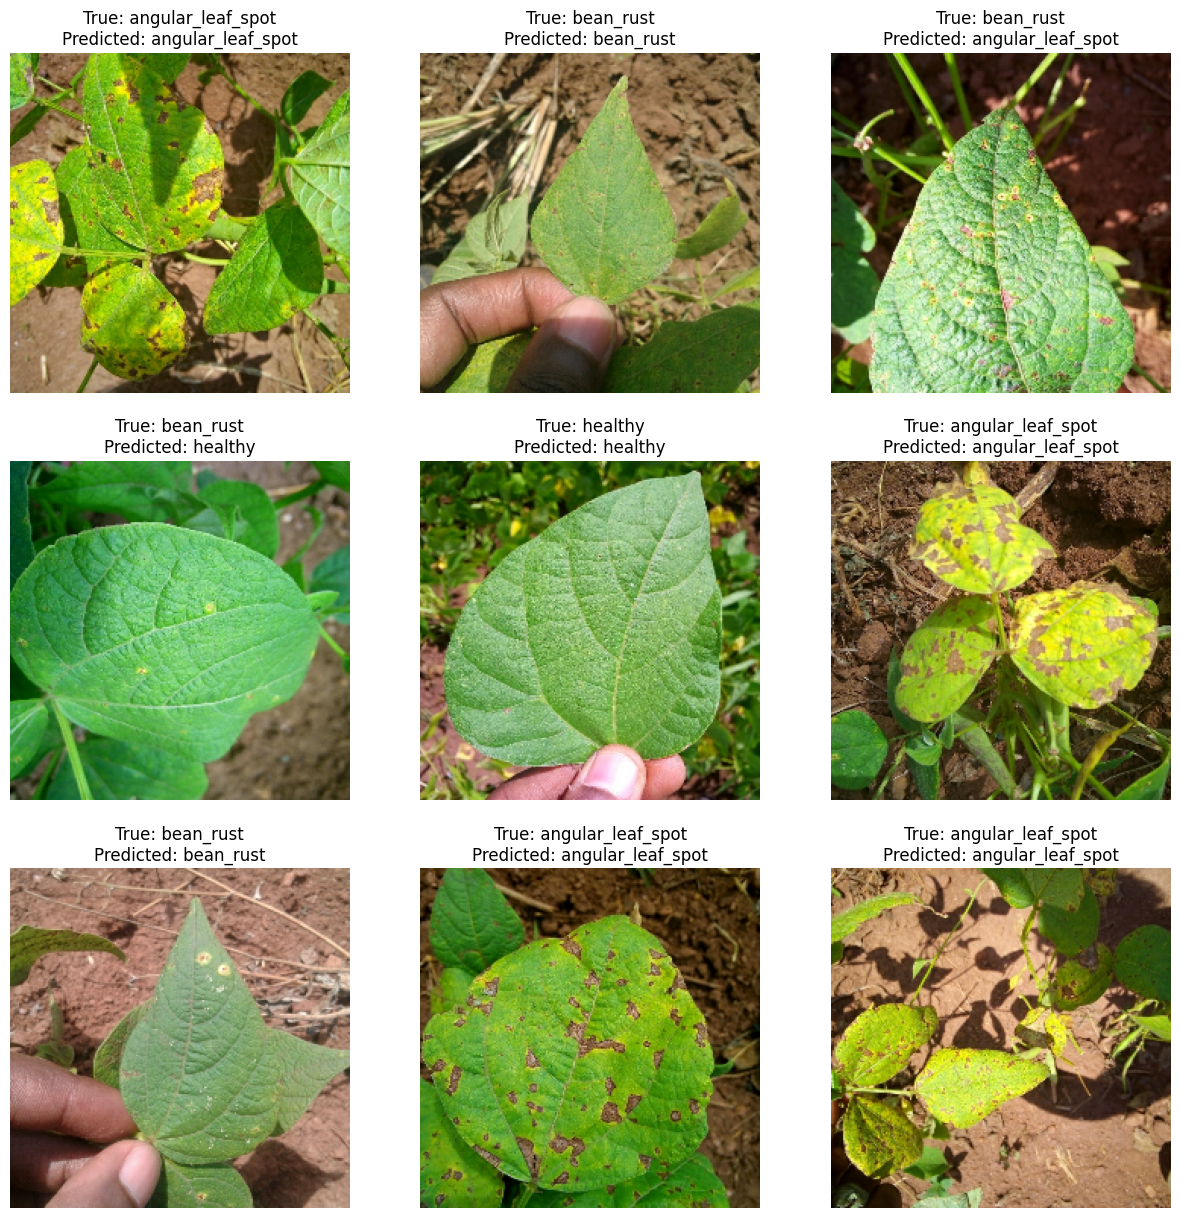

In [8]:

# Step 8: Predict on the Test Data
test_images, test_labels = next(iter(ds_test))
predictions = model.predict(test_images)

# Step 9: Visualize the Results on Test Samples
plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].numpy())
    predicted_label = class_names[tf.argmax(predictions[i])]
    true_label = class_names[test_labels[i].numpy()]
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis("off")
plt.show()

In [9]:
#Inbuilt model evaluation
# model.evaluate(test_images
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(ds_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 720ms/step - accuracy: 0.9031 - loss: 0.1873
Test Loss: 0.17428350448608398
Test Accuracy: 0.90625


In [10]:
#Evaluate with Custom Metrics
from sklearn.metrics import precision_recall_fscore_support


# Get predictions on the entire test dataset
predictions = model.predict(ds_test)

# Convert predictions to class labels (assuming softmax output)
predicted_classes = tf.argmax(predictions, axis=1).numpy()

# Extract true labels from the test dataset
true_labels = tf.concat([y for x, y in ds_test], axis=0).numpy()

# Compute precision, recall, F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_classes)

for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall:    {recall[i]:.2f}")
    print(f"  F1 Score:  {f1[i]:.2f}")



4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 771ms/step
Class: angular_leaf_spot
  Precision: 0.87
  Recall:    0.93
  F1 Score:  0.90
Class: bean_rust
  Precision: 0.88
  Recall:    0.84
  F1 Score:  0.86
Class: healthy
  Precision: 0.98
  Recall:    0.95
  F1 Score:  0.96


                   precision    recall  f1-score   support

angular_leaf_spot       0.87      0.93      0.90        43
        bean_rust       0.88      0.84      0.86        43
          healthy       0.98      0.95      0.96        42

         accuracy                           0.91       128
        macro avg       0.91      0.91      0.91       128
     weighted avg       0.91      0.91      0.91       128

[[40  3  0]
 [ 6 36  1]
 [ 0  2 40]]


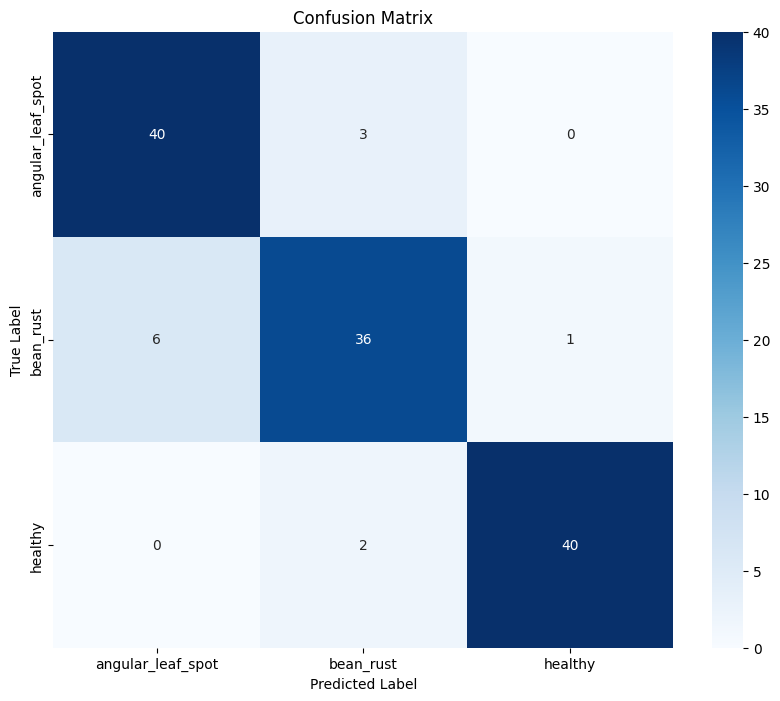

In [11]:
#Compute Metrics
#Use libraries like scikit-learn for more metrics:
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print(classification_report(true_labels, predicted_classes, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_classes)
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [12]:
model.save('C:/Users/Vignesh/Downloads/SRM/Sem/Deep Learning/model/mobilenetv2_beans_model.h5')

In [13]:
model.save('C:/Users/Vignesh/Downloads/SRM/Sem/Deep Learning/model/mobilenetv2_beans_model.keras')

In [ ]:
#Streamlit code for deploy
#streamlit run app.py

import streamlit as st
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

# Load the saved model
#MODEL_PATH = 'bean_disease_model.keras'
MODEL_PATH='C:/Users/Vignesh/Downloads/SRM/Sem/Deep Learning/model/mobilenetv2_beans_model.keras'
model = load_model(MODEL_PATH)

# Define the class names (replace with your actual class names)
class_names = ['Healthy', 'Angular Leaf Spot', 'Bean Rust']

# Function to preprocess the uploaded image
def preprocess_image(image):
    img = image.resize((128, 128))  # Resize to model's expected input size
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Streamlit App
st.title("Bean Disease Classification")
st.write("Upload an image of a bean leaf to identify its health condition.")

# File uploader
uploaded_file = st.file_uploader("Choose a bean leaf image", type=["jpg", "jpeg", "png"])

if uploaded_file:
    try:
        # Display the uploaded image
        image = Image.open(uploaded_file)
        st.image(image, caption="Uploaded Image", use_column_width=True)

        # Preprocess the image
        processed_image = preprocess_image(image)

        # Make a prediction
        predictions = model.predict(processed_image)
        predicted_class = class_names[np.argmax(predictions)]
        confidence = np.max(predictions) * 100

        # Display the result
        st.write(f"**Predicted Class:** {predicted_class}")
        st.write(f"**Confidence:** {confidence:.2f}%")
    except Exception as e:
        st.error(f"An error occurred: {e}")

# Error handling for unsupported file types
else:
    st.write("Please upload a valid image file.")
